# Import Needed Libs and Load data

In [3]:
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import emoji
import matplotlib.pyplot as plt
from nltk.util import ngrams
import matplotlib
import contractions
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from typing import Tuple
from typing import List


In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))
WNL = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv("../data/raw/mbti_1.csv")

In [6]:
# Split the data first to avoid data leakage
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['type']
)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 6940, Test size: 1735


# Data Preprocessing

In [7]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [8]:
df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [9]:
def clean_text(text: str) -> str:
    """Clean raw text by removing URLs, emojis, mentions, and MBTI codes."""
    text = text.lower()
    text = re.sub(r'https?\S+|www\S+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\']", ' ', text)
    # Remove MBTI type codes (e.g., INFJ, ENTP) to avoid leaking information
    text = re.sub(r'\b(I|E)(N|S)(F|T)(J|P)\b', '', text, flags=re.IGNORECASE)
    # Remove common footer
    text = re.sub(r'\bsent (from )?my \w+(\s\w+)? using tapatalk\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'w w w', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [10]:
def preprocess_posts(posts_str: str) -> str:
    """Split multi-post string (separated by '|||'), clean each, and join."""
    posts = posts_str.split('|||')
    cleaned_posts = [clean_text(post) for post in posts]
    joined = ' '.join(cleaned_posts)
    return re.sub(r'\s+', ' ', joined).strip()

In [11]:

print("Cleaning posts for train...")
tqdm.pandas()
train_df['cleaned_posts'] = train_df['posts'].progress_apply(preprocess_posts)

print("Cleaning posts for test...")
test_df['cleaned_posts'] = test_df['posts'].progress_apply(preprocess_posts)

Cleaning posts for train...


100%|██████████| 6940/6940 [00:47<00:00, 145.46it/s]


Cleaning posts for test...


100%|██████████| 1735/1735 [00:11<00:00, 152.50it/s]


In [13]:


def encode_mbti_type(mbti: str) -> Tuple[int, int, int, int]:
    """
    Encode MBTI type as 4 binary dimensions:
    I/E → 1/0, N/S → 1/0, F/T → 1/0, J/P → 1/0
    """
    return (
        1 if mbti[0] == 'I' else 0,
        1 if mbti[1] == 'N' else 0,
        1 if mbti[2] == 'F' else 0,
        1 if mbti[3] == 'J' else 0,
    )

In [14]:
# Encode labels for train and test
print("Encoding MBTI types for train...")
train_df[['IE', 'NS', 'FT', 'JP']] = pd.DataFrame(
    train_df['type'].progress_apply(encode_mbti_type).tolist(),
    index=train_df.index
)

print("Encoding MBTI types for test...")
test_df[['IE', 'NS', 'FT', 'JP']] = pd.DataFrame(
    test_df['type'].progress_apply(encode_mbti_type).tolist(),
    index=test_df.index
)

Encoding MBTI types for train...


100%|██████████| 6940/6940 [00:00<00:00, 790518.43it/s]


Encoding MBTI types for test...


100%|██████████| 1735/1735 [00:00<00:00, 762001.83it/s]


_______________

In [16]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag: str) -> str:
    """Map POS tag to WordNet format for lemmatization."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tokenize_text(text: str) -> List[str]:
    """Expand contractions, tokenize, remove stopwords, and lemmatize."""
    fixed = contractions.fix(text)
    tokens = word_tokenize(fixed)
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]
    pos_tags = nltk.pos_tag(filtered_tokens)
    lemmatized = [
        WNL.lemmatize(token, pos=get_wordnet_pos(pos))
        for token, pos in pos_tags
    ]
    return lemmatized

tqdm.pandas()


print("Tokenizing and lemmatizing for train...")
train_df['tokens'] = train_df['cleaned_posts'].progress_apply(tokenize_text)

print("Tokenizing and lemmatizing for test...")
test_df['tokens'] = test_df['cleaned_posts'].progress_apply(tokenize_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mayasalkhateeb/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Tokenizing and lemmatizing for train...


100%|██████████| 6940/6940 [03:53<00:00, 29.72it/s]


Tokenizing and lemmatizing for test...


100%|██████████| 1735/1735 [00:54<00:00, 31.95it/s]


In [17]:
def generate_ngrams(tokens: List[str]) -> Tuple[List, List, List]:
    """Generate unigrams, bigrams, and trigrams from token list."""
    unigrams = list(ngrams(tokens, 1))
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    return unigrams, bigrams, trigrams

In [18]:
# Generate n-grams for train and test
print("📊 Generating n-grams for train...")
ngram_results_train = train_df['tokens'].progress_apply(generate_ngrams)
train_df[['Unigrams', 'Bigrams', 'Trigrams']] = pd.DataFrame(
    ngram_results_train.tolist(), index=train_df.index
)

print("📊 Generating n-grams for test...")
ngram_results_test = test_df['tokens'].progress_apply(generate_ngrams)
test_df[['Unigrams', 'Bigrams', 'Trigrams']] = pd.DataFrame(
    ngram_results_test.tolist(), index=test_df.index
)

📊 Generating n-grams for train...


100%|██████████| 6940/6940 [00:01<00:00, 4631.39it/s]


📊 Generating n-grams for test...


100%|██████████| 1735/1735 [00:00<00:00, 4557.75it/s]


In [19]:
# Word count stats (on train for EDA)
train_df['word_count'] = train_df['tokens'].apply(len)
print("Word Count Statistics (Train):")
print(train_df['word_count'].describe())

Word Count Statistics (Train):
count    6940.000000
mean      598.134438
std       140.336013
min         1.000000
25%       519.000000
50%       623.000000
75%       702.000000
max       906.000000
Name: word_count, dtype: float64


In [21]:
train_df.head()

,type,posts,cleaned_posts,IE,NS,FT,JP,tokens,Unigrams,Bigrams,Trigrams,word_count
8331,INFP,'this is actually exactly what i expected! :l...,'this is actually exactly what i expected laug...,1,1,1,0,"['this, actually, exactly, expect, laugh, intr...","[('this,), (actually,), (exactly,), (expect,),...","[('this, actually), (actually, exactly), (exac...","[('this, actually, exactly), (actually, exactl...",722
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",'nope not now not ever i'm too busy with work ...,1,0,0,0,"['nope, ever, busy, work, cause, adrenaline, r...","[('nope,), (ever,), (busy,), (work,), (cause,)...","[('nope, ever), (ever, busy), (busy, work), (w...","[('nope, ever, busy), (ever, busy, work), (bus...",642
1982,ENFJ,'Yes peace is the absence of conflict - your I...,'yes peace is the absence of conflict your fri...,0,1,1,1,"['yes, peace, absence, conflict, friend, suxx,...","[('yes,), (peace,), (absence,), (conflict,), (...","[('yes, peace), (peace, absence), (absence, co...","[('yes, peace, absence), (peace, absence, conf...",591
769,INFP,"'I apologize for the delayed response, but tha...",'i apologize for the delayed response but than...,1,1,1,0,"[', apologize, delay, response, thank, taking,...","[(',), (apologize,), (delay,), (response,), (t...","[(', apologize), (apologize, delay), (delay, r...","[(', apologize, delay), (apologize, delay, res...",639
8339,INFP,"'Nightglow, I can't even imagine what you must...",'nightglow i can't even imagine what you must ...,1,1,1,0,"['nightglow, even, imagine, must, struggle, ri...","[('nightglow,), (even,), (imagine,), (must,), ...","[('nightglow, even), (even, imagine), (imagine...","[('nightglow, even, imagine), (even, imagine, ...",704


In [24]:
def analyze_class_distribution(df: pd.DataFrame):
    # 16 types
    type_counts = df['type'].value_counts()
    print("MBTI Type Distribution:\n", type_counts)
    
    # Dichotomies (using binary encodings)
    dichotomy_counts = {
        'I/E': df['IE'].value_counts(normalize=True) * 100,  # 1=I, 0=E
        'N/S': df['NS'].value_counts(normalize=True) * 100,  # 1=N, 0=S
        'F/T': df['FT'].value_counts(normalize=True) * 100,  # 1=F, 0=T
        'J/P': df['JP'].value_counts(normalize=True) * 100,  # 1=J, 0=P
    }
    print("Dichotomy Percentages:\n", pd.DataFrame(dichotomy_counts))
    
    # Plot 16 types
    plt.figure(figsize=(12, 6))
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('MBTI Type Distribution')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

MBTI Type Distribution:
 type
INFP    1466
INFJ    1176
INTP    1043
INTJ     873
ENTP     548
ENFP     540
ISTP     270
ISFP     217
ENTJ     185
ISTJ     164
ENFJ     152
ISFJ     133
ESTP      71
ESFP      38
ESFJ      33
ESTJ      31
Name: count, dtype: int64
Dichotomy Percentages:
          I/E        N/S        F/T        J/P
0  23.025937  13.789625  45.893372  60.417867
1  76.974063  86.210375  54.106628  39.582133


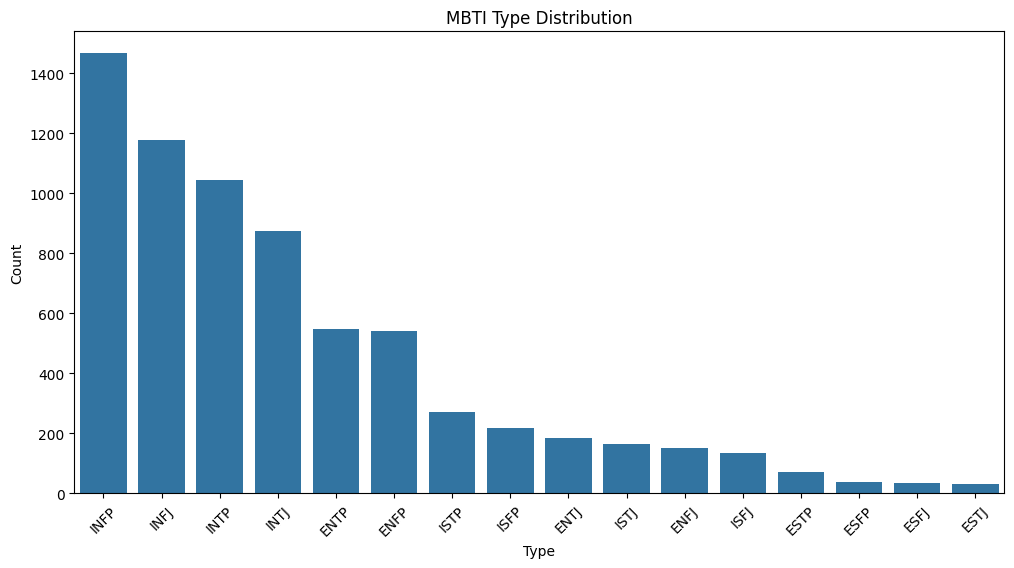

In [25]:
# Perform analysis on train set for EDA
analyze_class_distribution(train_df)

In [26]:
X_train = train_df['cleaned_posts']
X_test = test_df['cleaned_posts']
y_train = train_df[['IE', 'NS', 'FT', 'JP']]
y_test = test_df[['IE', 'NS', 'FT', 'JP']]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 6940, Test size: 1735
